## Language data cleaning & EDA

In [1]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### 1. Load data and delete unnecessary columns

In [2]:
df = pd.read_csv('./clean_data_2.csv', index_col=0)

In [3]:
df.head(3)

,brand,description,item_id,status,title,url,original_price,new_price,tag_1,tag_2,tag_3,title_emoji,description_emoji
0,Zenana Outfitters,"Zenana Premium shirt, size large, came from a ...",5c76992f819e9019dc35783d,Buy Now,Zenana Premium shirt,https://poshmark.com/listing/Zenana-Premium-sh...,25.0,13.0,Women,Tops,Blouses,0,0
1,Dansko,Like New\nOnly worn a few times\nNo wear signs...,5c76989bfe5151cc53579bce,Buy Now,Dansko Black Leather Mary Janes,https://poshmark.com/listing/Dansko-Black-Leat...,0.0,25.0,Women,NaN,NaN,0,0
2,Matisse,Amazing pair of leopard print pony hair wedge ...,5c7694f9df03079e3a8c89cf,Buy Now,Matisse Leopard Wedge Bootie,https://poshmark.com/listing/Matisse-Leopard-W...,215.0,80.0,Women,Shoes,AnkleBoots&Booties,0,0


In [4]:
# Check for nulls using item_id column
df['item_id'].isnull().sum()

0

### 2. Delete rows with status='Not For Sale'

In [5]:
not_for_sale = list(df[df['status'] == 'Not For Sale'].index)

In [6]:
# # See what kind of words/phrases appear in posts that are LABELED 'Not For Sale'
# df.loc[not_for_sale]['description']

In [7]:
# Drop rows with 'status' of 'Not For Sale'
df.drop(index=not_for_sale, inplace=True)
df.reset_index(inplace=True, drop=True)

### 3. Regex to find "spam" posts

In [8]:
# Phrases that indicate a "spam" post
find_spam_title = [
    'coming soon',
    'not for sale',
    'handmade',
    'ambassador', 
    'follow', 
    'instagram',
    'facebook',
    'twitter',
    'listing',
    'deal',
    'bundle',
    'bogo',
    'sale',
    'clear out']

find_spam_desc = [
    'coming soon',
    'not for sale', 
    'handmade']

In [9]:
# Create empty lists to house index numbers that correspond to spam posts
spam_title_num = []
spam_desc_num = []

In [10]:
def spam_title(pattern_list=find_spam_title, df=df):
    for phrase in pattern_list:
        pattern = re.compile(phrase, re.IGNORECASE)
        for i in range(len(df)):
            if re.search(pattern, df['title'][i]):
#                 print(i, df['title'][i])
                spam_title_num.append(i)

In [11]:
def spam_description(pattern_list=find_spam_desc, df=df):
    for phrase in pattern_list:
        pattern = re.compile(phrase, re.IGNORECASE)
        for i in range(len(df)):
            if re.search(pattern, df['description'][i]):
#                 print(i, df['description'][i])
                spam_desc_num.append(i)

In [12]:
# Run functions
spam_title()
spam_description()

In [13]:
# Combine lists of index numbers
all_spam_rows = spam_title_num + spam_desc_num

In [14]:
# Eliminate duplicate numbers in list
all_spam_rows = list(set(all_spam_rows))

In [15]:
spam = df.loc[all_spam_rows]

In [16]:
len(spam)

171

In [17]:
# # Look at identified spam posts
# spam.sort_values(by='original_price', ascending=False)

In [18]:
# Drop spam rows and reset index
df.drop(index=all_spam_rows, inplace=True)
df.reset_index(inplace=True, drop=True)

### 4. More EDA to find "spam" posts

#### 1. `Bogus titles`

In [19]:
# Find items with bogus titles
drop = []

for i in range(len(df)):
    if len(df['title'][i]) <= 2:
        drop.append(i)
    else:
        pass

In [20]:
# # DataFrame with only bogus title posts
# df.loc[drop]

In [21]:
# Drop spam rows and reset index
df.drop(index=drop, inplace=True)
df.reset_index(inplace=True, drop=True)

#### 2. `Bogus descriptions`

In [22]:
# Find items with bogus descriptions, i.e. with very few characters as a placeholder for an actual description
drop = []

for i in range(len(df)):
    if len(df['description'][i]) == 1:
        drop.append(i)
    else:
        pass

In [23]:
# DataFrame with only bogus description posts
drop = df.loc[drop]

In [24]:
# Reset drop variable as a list of index numbers to drop
# Filter on 'original_price' == 0 & 'brand' = null
drop = list(drop[(drop['original_price'] == 0) &
    (drop['brand'].isnull())].index)

In [25]:
# Drop spam rows and reset index
df.drop(index=drop, inplace=True)
df.reset_index(inplace=True, drop=True)

### 5. Tags

#### `tag_1`

In [26]:
# Double check that 'Women' is 'tag_1' for every post
set(list(df['tag_1']))

{'Women'}

#### `tag_2`

In [27]:
tag_2 = list(set(list(df['tag_2'])))

In [28]:
len(tag_2)

16

In [29]:
# Create dummy variables for tags (item categories)
df = pd.get_dummies(df, columns=['tag_2'], drop_first=True)

#### `tag_3`

In [30]:
tag_3 = list(set(list(df['tag_3'])))

In [31]:
# Look to see how many sub-tags there are so we can figure out if it's worth including them in this model
len(tag_3)

126

### 6. Tokenize, Lemmatize, Vectorize, etc.

#### 1. Look at `title` and `description` columns

In [32]:
# Instantiate NLP functions
tokenizer = RegexpTokenizer(r'\w+', gaps=False)
lemmatizer = WordNetLemmatizer()

In [33]:
# Access each title individually
titles = [df.iloc[i]['title'] for i in range(len(df))]
descriptions = [df.iloc[i]['description'] for i in range(len(df))]


In [34]:
# titles[:3]
# descriptions[:2]

#### 2. `Tokenize`

In [35]:
# Tokenize all titles
def tokenize(text):
    for i in range(len(text)):
        text[i] = tokenizer.tokenize(text[i].lower())

In [36]:
tokenize(titles)
tokenize(descriptions)

In [37]:
# titles[:3]
# descriptions[:2]

#### 3. `Remove stop words`

In [38]:
# # Remove stop words
# def stop_words(text):
#     for i in range(len(text)):
#         raw_words = text[i]
#         text[i] = [w for w in raw_words if not w in stopwords.words('english')]
        

In [39]:
# stop_words(titles)
# stop_words(descriptions)

In [40]:
# titles[:3]
# descriptions[:2]

#### 4. `Lemmatize`

In [41]:
# Lemmatize all titles
def lemm(text, empty_list):
    for x in range(len(text)):
        lemm_list = []
        for i in text[x]:
            lemm_list.append(lemmatizer.lemmatize(i))
        empty_list.append(lemm_list)

In [42]:
empty_titles = []

lemm(titles, empty_titles)

In [43]:
empty_descriptions = []

lemm(descriptions, empty_descriptions)

In [44]:
# empty_titles[:3]
# empty_descriptions[:2]

#### 5. Rejoin strings

In [45]:
# Join strings in list
for i in range(len(df)):
    titles[i] = ' '.join(empty_titles[i])
    descriptions[i] = ' '.join(empty_descriptions[i])

In [46]:
# titles[:3]
# descriptions[:2]

#### 6. `Count Vectorizer & ngrams`

In [47]:
t_corpus = titles
d_corpus = descriptions

##### a. words

In [48]:
t_vect = CountVectorizer(ngram_range=(1,1), stop_words='english')
d_vect = CountVectorizer(ngram_range=(1,1), stop_words='english')

In [49]:
t_text = t_vect.fit_transform(t_corpus)
d_text = d_vect.fit_transform(d_corpus)

In [50]:
# # Get list of all words
# t_vect.get_feature_names()
# d_vect.get_feature_names()

In [51]:
# Vectorized title words
title_words = pd.DataFrame(t_text.toarray(),
                         columns=t_vect.get_feature_names())

In [52]:
# Vectorized description words
description_words = pd.DataFrame(d_text.toarray(),
                                columns=d_vect.get_feature_names())

In [53]:
# # View vector DataFrames
# title_words
# description_words

In [54]:
# Concat all features
all_words = pd.concat([title_words, description_words], axis=1)

In [55]:
# Concat words AND other features
words_df = pd.concat([df, all_words], axis=1)

In [56]:
words_df.head(3)

,brand,description,item_id,status,title,url,original_price,new_price,tag_1,tag_3,...,ᴛʜᴇʀᴇ,𝑀𝒶𝓉𝑒𝓇𝒾𝒶𝓁𝓈,𝑅𝑒𝓉𝓊𝓇𝓃𝓈,𝑒𝓍𝒸𝒽𝒶𝓃𝑔𝑒𝓈,𝒮𝓉𝓎𝓁𝑒,𝒲𝒽𝒶𝓉,𝒸𝑜𝓃𝒹𝒾𝓉𝒾𝑜𝓃,𝒻𝒾𝓉,𝓈𝒾𝓏𝑒,𝓉𝒽𝑒
0,Zenana Outfitters,"Zenana Premium shirt, size large, came from a ...",5c76992f819e9019dc35783d,Buy Now,Zenana Premium shirt,https://poshmark.com/listing/Zenana-Premium-sh...,25.0,13.0,Women,Blouses,...,0,0,0,0,0,0,0,0,0,0
1,Dansko,Like New\nOnly worn a few times\nNo wear signs...,5c76989bfe5151cc53579bce,Buy Now,Dansko Black Leather Mary Janes,https://poshmark.com/listing/Dansko-Black-Leat...,0.0,25.0,Women,NaN,...,0,0,0,0,0,0,0,0,0,0
2,Matisse,Amazing pair of leopard print pony hair wedge ...,5c7694f9df03079e3a8c89cf,Buy Now,Matisse Leopard Wedge Bootie,https://poshmark.com/listing/Matisse-Leopard-W...,215.0,80.0,Women,AnkleBoots&Booties,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# words_df.to_csv('./words_df.csv')

In [156]:
# Top words from ALL titles
top = pd.DataFrame(title_words.sum().sort_values(0, ascending=False).head(20))

# Rename column
top.rename(columns={0:'words'}, inplace=True)

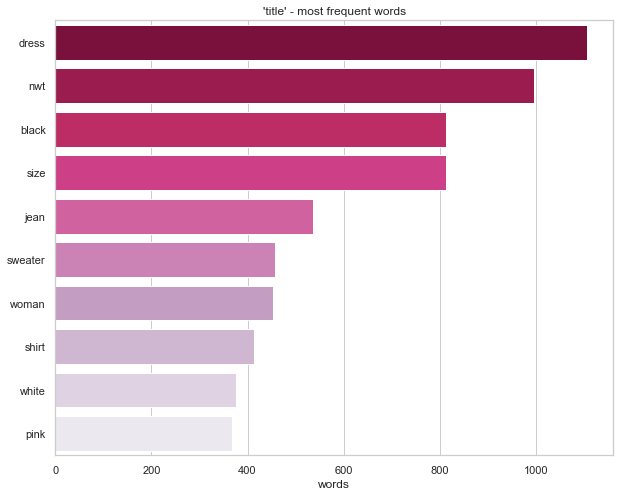

In [161]:
# Graphed
plt.figure(figsize=(10,8))
plt.title("'title' - most frequent words")
sns.barplot(x=top.words, 
            y=top.index, 
            data=top, 
            palette='PuRd_r');

In [162]:
# # Graphed
# title_words.sum().sort_values(0, ascending=True).tail(20).plot(kind='barh');

In [61]:
# # Top words from ALL descriptions
# description_words.sum().sort_values(0, ascending=False).head(10)

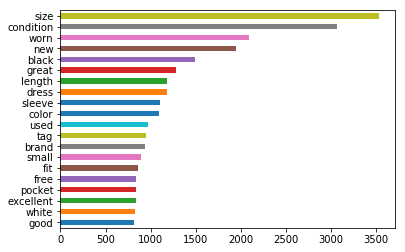

In [62]:
# Graphed
description_words.sum().sort_values(0, ascending=True).tail(20).plot(kind='barh');

In [63]:
# # Top words from one title
# title_words.iloc[5].sort_values(0, ascending=False)

In [64]:
# # Looking for weird words like this:
# title_words[title_words['ғαcєвσσĸ'] == 1]

In [65]:
# # Isolate specific term and find rows that contain it
# oo = list(title_words[title_words['00'] == 1].index)
# df.iloc[oo]

##### b. `bi-grams & trigrams`

In [66]:
t_vect_n = CountVectorizer(ngram_range=(2,3), stop_words='english')
d_vect_n = CountVectorizer(ngram_range=(2,3), stop_words='english')

In [67]:
t_text = t_vect_n.fit_transform(t_corpus)
d_text = d_vect_n.fit_transform(d_corpus)

In [68]:
# # Get list of all words
# t_vect_n.get_feature_names()
# d_vect_n.get_feature_names()

In [69]:
# Vectorized title words
title_ngrams = pd.DataFrame(t_text.toarray(),
                         columns=t_vect_n.get_feature_names())

In [70]:
# Vectorized description words
description_ngrams = pd.DataFrame(d_text.toarray(),
                                columns=d_vect_n.get_feature_names())

In [71]:
# # View vector DataFrames
# title_ngrams
# description_ngrams

In [72]:
# Concat all features
all_ngrams = pd.concat([title_ngrams, description_ngrams], axis=1)

In [73]:
ngram_df = pd.concat([df, all_ngrams], axis=1)

In [74]:
# ngram_df.to_csv('./ngram_df.csv')

In [75]:
# # Top bi-grams/tri-grams from ALL titles
# title_ngrams.sum().sort_values(0, ascending=False).head(10)

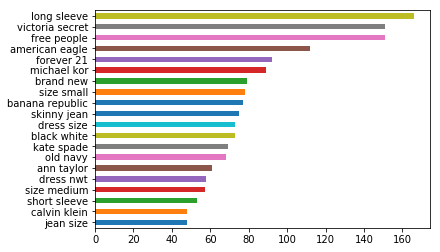

In [76]:
# Graphed
title_ngrams.sum().sort_values(0, ascending=True).tail(20).plot(kind='barh');

In [77]:
# # Top bi-grams/tri-grams from ALL descriptions
# description_ngrams.sum().sort_values(0, ascending=False).head(10)

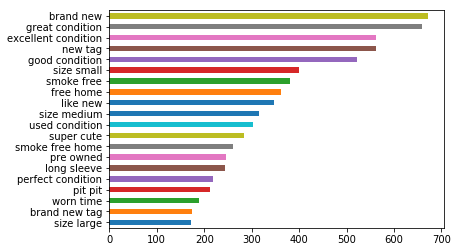

In [90]:
# Graphed
description_ngrams.sum().sort_values(0, ascending=True).tail(20).plot(kind='barh');

#### 7. Put clean title/description into DataFrame

In [79]:
# Create empty DataFrame
clean = pd.DataFrame(index=df.index,
                          columns=['clean_title', 
                                   'clean_description'])


In [80]:
# Input clean titles
for i in range(len(titles)):
    clean['clean_title'][i] = titles[i]
    clean['clean_description'][i] = descriptions[i]

In [81]:
# Concatenate two DataFrames
df = pd.concat([df, clean], axis=1)

In [82]:
df.head(3)

,brand,description,item_id,status,title,url,original_price,new_price,tag_1,tag_3,...,tag_2_Makeup,tag_2_Pants,tag_2_Shoes,tag_2_Shorts,tag_2_Skirts,tag_2_Sweaters,tag_2_Swim,tag_2_Tops,clean_title,clean_description
0,Zenana Outfitters,"Zenana Premium shirt, size large, came from a ...",5c76992f819e9019dc35783d,Buy Now,Zenana Premium shirt,https://poshmark.com/listing/Zenana-Premium-sh...,25.0,13.0,Women,Blouses,...,0,0,0,0,0,0,0,1,zenana premium shirt,zenana premium shirt size large came from a lo...
1,Dansko,Like New\nOnly worn a few times\nNo wear signs...,5c76989bfe5151cc53579bce,Buy Now,Dansko Black Leather Mary Janes,https://poshmark.com/listing/Dansko-Black-Leat...,0.0,25.0,Women,NaN,...,0,0,0,0,0,0,0,0,dansko black leather mary janes,like new only worn a few time no wear sign doe...
2,Matisse,Amazing pair of leopard print pony hair wedge ...,5c7694f9df03079e3a8c89cf,Buy Now,Matisse Leopard Wedge Bootie,https://poshmark.com/listing/Matisse-Leopard-W...,215.0,80.0,Women,AnkleBoots&Booties,...,0,0,1,0,0,0,0,0,matisse leopard wedge bootie,amazing pair of leopard print pony hair wedge ...


In [83]:
# Find rows where `clean_title` is null
df[df['clean_title'].isnull()]

,brand,description,item_id,status,title,url,original_price,new_price,tag_1,tag_3,...,tag_2_Makeup,tag_2_Pants,tag_2_Shoes,tag_2_Shorts,tag_2_Skirts,tag_2_Sweaters,tag_2_Swim,tag_2_Tops,clean_title,clean_description


In [84]:
df['clean_title'].dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

In [85]:
df[df['clean_description'].isnull()]

,brand,description,item_id,status,title,url,original_price,new_price,tag_1,tag_3,...,tag_2_Makeup,tag_2_Pants,tag_2_Shoes,tag_2_Shorts,tag_2_Skirts,tag_2_Sweaters,tag_2_Swim,tag_2_Tops,clean_title,clean_description


In [86]:
# Replace null descriptions with a question mark
df['clean_description'].fillna('?', inplace=True)

In [87]:
# Check datatypes
df.dtypes

brand                         object
description                   object
item_id                       object
status                        object
title                         object
url                           object
original_price               float64
new_price                    float64
tag_1                         object
tag_3                         object
title_emoji                    int64
description_emoji              int64
tag_2_Bags                     uint8
tag_2_Dresses                  uint8
tag_2_Intimates&Sleepwear      uint8
tag_2_Jackets&Coats            uint8
tag_2_Jeans                    uint8
tag_2_Jewelry                  uint8
tag_2_Makeup                   uint8
tag_2_Pants                    uint8
tag_2_Shoes                    uint8
tag_2_Shorts                   uint8
tag_2_Skirts                   uint8
tag_2_Sweaters                 uint8
tag_2_Swim                     uint8
tag_2_Tops                     uint8
clean_title                   object
c

In [88]:
df.head(3)

,brand,description,item_id,status,title,url,original_price,new_price,tag_1,tag_3,...,tag_2_Makeup,tag_2_Pants,tag_2_Shoes,tag_2_Shorts,tag_2_Skirts,tag_2_Sweaters,tag_2_Swim,tag_2_Tops,clean_title,clean_description
0,Zenana Outfitters,"Zenana Premium shirt, size large, came from a ...",5c76992f819e9019dc35783d,Buy Now,Zenana Premium shirt,https://poshmark.com/listing/Zenana-Premium-sh...,25.0,13.0,Women,Blouses,...,0,0,0,0,0,0,0,1,zenana premium shirt,zenana premium shirt size large came from a lo...
1,Dansko,Like New\nOnly worn a few times\nNo wear signs...,5c76989bfe5151cc53579bce,Buy Now,Dansko Black Leather Mary Janes,https://poshmark.com/listing/Dansko-Black-Leat...,0.0,25.0,Women,NaN,...,0,0,0,0,0,0,0,0,dansko black leather mary janes,like new only worn a few time no wear sign doe...
2,Matisse,Amazing pair of leopard print pony hair wedge ...,5c7694f9df03079e3a8c89cf,Buy Now,Matisse Leopard Wedge Bootie,https://poshmark.com/listing/Matisse-Leopard-W...,215.0,80.0,Women,AnkleBoots&Booties,...,0,0,1,0,0,0,0,0,matisse leopard wedge bootie,amazing pair of leopard print pony hair wedge ...


In [89]:
df.to_csv('./clean_data_3.csv')